In [35]:
if __name__ == '__main__':
    import sys
    import os
    from pathlib import Path
    curr_file_path = Path(os.path.abspath(''))
    sys.path.append(str(curr_file_path.parent))

import numpy as np
import glob2 as glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
import pickle
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from aux_funcs import colored_line, compressed_read
from imblearn.under_sampling import RandomUnderSampler
# from aux_funcs import parse_string_with_regex, ordered_colors_from_cmap

N_ENVS = 30

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 3.0

In [36]:
def load_numpy(data_path, averaging_size=1):
    file_names = glob.glob(data_path)
    data = []
    for file_name in file_names:
        data_for_file = np.load(file_name)
        data.append(data_for_file)
    data = np.concatenate(data, axis=1)
    if averaging_size == 1:
        return data
    reduced_data = np.empty((data.shape[0], int(data.shape[1] / averaging_size)))
    for k in range(0, int(data.shape[1] / averaging_size) * averaging_size, averaging_size):
        reduced_data[:, int(k / averaging_size)] = data[:, k:k + averaging_size].mean(axis=1)
    return reduced_data

def load_data(data_path, indices=[]):
#     file_names = glob.glob(data_path)
    file_names = sorted(os.listdir(data_path))
    print(file_names)
    for fidx, file_name in enumerate(file_names):
        if fidx in indices or (len(indices) == 0 and fidx + 1 == len(file_names)):
            data_for_file = pickle.load(open(os.path.join(data_path, file_name), 'rb'))
            yield data_for_file

def load_compressed_data(data_path, indices=[], all=False):
    file_names = sorted(os.listdir(data_path))
    print(file_names)

    
    for fidx, file_name in enumerate(file_names):
        if fidx in indices or (len(indices) == 0 and fidx + 1 == len(file_names)) or all:
            data_for_file = compressed_read(os.path.join(data_path, file_name))
            yield data_for_file

def parse_session(data_path, update_num=None):
    indices = [] if update_num is None else [update_num]
    state_data = load_compressed_data(
        data_path,
        all=True,
    )

    features = [
        'current_patch_num',
        'reward_site_idx',
        'current_reward_site_attempted',
        'agent_in_patch',
        'patch_reward_param',
        'action',
        'reward',
    ]

    all_time_series_dicts = []

    for d in state_data:
        for env_idx in range(N_ENVS):
            features_to_time_series_dict = {}
            for f in features:
                features_to_time_series_dict[f] = np.zeros((len(d)), dtype=float)
            
            for k in np.arange(len(d)):
                for f in features:
                    features_to_time_series_dict[f][k] = d[k][f][env_idx]

        
            dwell_time = np.zeros((len(d)))
            rewards_seen_in_patch = np.zeros((len(d)))
            
            for idx in np.arange(0, len(d)):
                if idx > 0 and features_to_time_series_dict['action'][idx] == 0:
                    dwell_time[idx] = dwell_time[idx-1] + 1
                else:
                    dwell_time[idx] = 0

                if features_to_time_series_dict['agent_in_patch'][idx]:
                    if idx > 0:
                        rewards_seen_in_patch[idx] = rewards_seen_in_patch[idx-1] + features_to_time_series_dict['reward'][idx]
                    else:
                        rewards_seen_in_patch[idx] = features_to_time_series_dict['reward'][idx]
        
            features_to_time_series_dict['dwell_time'] = dwell_time
            features_to_time_series_dict['rewards_seen_in_patch'] = rewards_seen_in_patch
            all_time_series_dicts.append(features_to_time_series_dict)
        
    return all_time_series_dicts

def find_patch_trajectories(agent_in_patch_ts):
    starts_and_stops = []
    start_idx = None
    for k in np.arange(len(agent_in_patch_ts)):
        if agent_in_patch_ts[k] > 0:
            if start_idx is None:
                start_idx = k
        elif (k > 0 and agent_in_patch_ts[k-1] > 0 and start_idx is not None):
            starts_and_stops.append(slice(start_idx, k))
            start_idx = None
    return starts_and_stops

def find_odor_site_trajectories(odor_site_indices, site_num=None):
    starts_and_stops = []
    start_idx = None
    for k in np.arange(len(odor_site_indices)):
        if (site_num is None and odor_site_indices[k] >= 0) or \
            odor_site_indices[k] == site_num:
            if start_idx is None:
                start_idx = k
        elif k > 0 and \
            ((odor_site_indices[k-1] >= 0 and site_num is None) or odor_site_indices[k-1] == site_num) and \
            start_idx is not None:
            starts_and_stops.append(slice(start_idx, k))
            start_idx = None
    return starts_and_stops

def find_trajectories_by_patch_type(session_data):
    patch_starts_and_ends = find_patch_trajectories(session_data['agent_in_patch'])
    trajs_by_patch_type = [[], [], []]
    for traj_idx, patch_traj_indices in enumerate(patch_starts_and_ends):
        patch_num = int(session_data['current_patch_num'][patch_traj_indices][0])
        trajs_by_patch_type[patch_num].append(patch_traj_indices)
    return trajs_by_patch_type

def find_odor_site_trajectories_by_patch_type(session_data, first_site_only=False, site_num=None):
    if first_site_only:
        site_num = 0
    patch_starts_and_ends = find_odor_site_trajectories(session_data['reward_site_idx'], site_num=site_num)
    trajs_by_patch_type = [[], [], []]
    for traj_idx, patch_traj_indices in enumerate(patch_starts_and_ends):
        patch_num = int(session_data['current_patch_num'][patch_traj_indices][0])
        trajs_by_patch_type[patch_num].append(patch_traj_indices)
    return trajs_by_patch_type

In [37]:
p = 'testing_network_trained_with_integrator_with_resets_2025-02-21_09_39_17_295736_var_noise_0_activity_weight_0'

data = load_numpy(f'../../results/rl_agent_outputs/{p}/hidden_state/*.npy')
all_session_data = parse_session(f'../../results/rl_agent_outputs/{p}/state')
all_session_data = np.array(all_session_data)
print(all_session_data.shape)

['00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']
(210,)


In [38]:
hidden_states = []
targets = []

for env_idx in range(0, 210):
    session_data = all_session_data[env_idx]
    trajs_by_patch_type = find_odor_site_trajectories_by_patch_type(session_data)
    for k in reversed(range(3)):
        trajs_for_patch_type = trajs_by_patch_type[k]
        for i in range(len(trajs_for_patch_type)):
            if i < 100:
                curr_traj = trajs_for_patch_type[i]
                hidden_states.append(data[curr_traj, env_idx, :])
                targets.append(np.array([
                    session_data['reward_site_idx'][curr_traj],
                    session_data['rewards_seen_in_patch'][curr_traj],
                    session_data['patch_reward_param'][curr_traj],
                ]))

hidden_states = np.concatenate(hidden_states, axis=0)
targets = np.concatenate(targets, axis=1).T

first_site_hidden_states = []
first_site_targets = []

for env_idx in range(0, 210):
    session_data = all_session_data[env_idx]
    trajs_by_patch_type = find_odor_site_trajectories_by_patch_type(session_data, first_site_only=True)
    for k in range(3):
        trajs_for_patch_type = trajs_by_patch_type[k]
        for i in range(len(trajs_for_patch_type)):
            if i < 100:
                curr_traj = trajs_for_patch_type[i]
                first_site_hidden_states.append(data[curr_traj, env_idx, :])
                first_site_targets.append(np.array([
                    session_data['patch_reward_param'][curr_traj],
                ]))

first_site_hidden_states = np.concatenate(first_site_hidden_states, axis=0)
first_site_targets = np.concatenate(first_site_targets, axis=1).T

[-0.9445842324662579, -0.9545849658114587, -0.9329984254813846, -0.8980439611945774, -0.9603393302789929]
[-0.8735301584255597, -0.8937337497022539, -0.889120335669451, -0.87765746993936, -0.9063894841096947]
[0.3977141601186878, 0.3989047017235379, 0.3968899390076378, 0.40082788431598804, 0.3998644589347205]
[0.38864804280246157, 0.38756952227885044, 0.3847569099329625, 0.3842363490250814, 0.39536014888127563]


(0.0, 1.1)

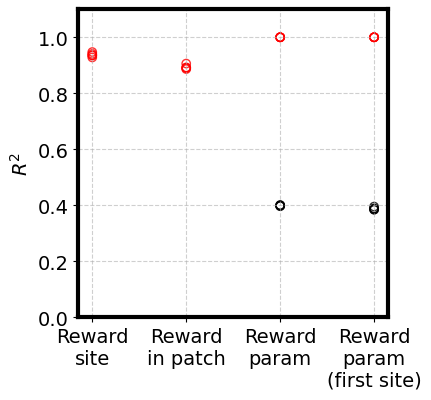

In [39]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
all_pred_accuracies = []

reg_types = [
    LinearRegression,
    LinearRegression,
    LogisticRegression,
]

for k in range(targets.shape[1]):
    pred_accuracies = []
    shuffled_pred_accuracies = []
    y = targets[:, k]
    
    kf = KFold(n_splits=5)
    for train_i, test_i in kf.split(hidden_states, y):
        # do normal regression
        if k == 2:
            classifier = reg_types[k](max_iter=int(1e6))
        else:
            classifier = reg_types[k]()
        reg = classifier.fit(hidden_states[train_i, :], y[train_i])
        pred_accuracies.append(reg.score(hidden_states[test_i, :], y[test_i]))
        # do regression with shuffled labels
        y_test = y[test_i]
        np.random.shuffle(y_test)
        shuffled_pred_accuracies.append(reg.score(hidden_states[test_i, :], y_test))

    
    all_pred_accuracies.append(pred_accuracies)
    axs.scatter(np.ones(5) * k, pred_accuracies, alpha=0.8, facecolor='none', edgecolor='red')
    print(shuffled_pred_accuracies)
    axs.scatter(np.ones(5) * k, shuffled_pred_accuracies, alpha=0.8, facecolor='none', edgecolor='black')

for k in range(first_site_targets.shape[1]):
    pred_accuracies = []
    shuffled_pred_accuracies = []
    y = first_site_targets[:, k]
    
    kf = KFold(n_splits=5)
    for train_i, test_i in kf.split(first_site_hidden_states, y):
        classifier = LogisticRegression(max_iter=int(1e6))
        reg = classifier.fit(first_site_hidden_states[train_i, :], y[train_i])
        pred_accuracies.append(reg.score(first_site_hidden_states[test_i, :], y[test_i]))
        # do regression with shuffled labels
        y_test = y[test_i]
        np.random.shuffle(y_test)
        shuffled_pred_accuracies.append(reg.score(first_site_hidden_states[test_i, :], y_test))

    all_pred_accuracies.append(pred_accuracies)
    x = np.ones(5) * k + targets.shape[1]
    axs.scatter(x, pred_accuracies, alpha=0.8, facecolor='none', edgecolor='red')
    print(shuffled_pred_accuracies)
    axs.scatter(x, shuffled_pred_accuracies, alpha=0.8, facecolor='none', edgecolor='black')


axs.set_ylabel(r'$R^2$')
axs.set_xticks(np.arange(targets.shape[1] + first_site_targets.shape[1]))
axs.set_xticklabels([
    'Reward\nsite',
    'Reward\nin patch',
    'Reward\nparam',
    'Reward\nparam\n(first site)',
])
axs.grid(True, linestyle='--', alpha=0.6)
axs.set_ylim(0, 1.1)

In [40]:
covariates = []
targets = []

for env_idx in range(0, 210):
    session_data = all_session_data[env_idx]
    trajs_by_patch_type = find_odor_site_trajectories_by_patch_type(session_data)
    for k in reversed(range(3)):
        trajs_for_patch_type = trajs_by_patch_type[k]

        reward_history = []
        for i in range(len(trajs_for_patch_type)):
            curr_traj = trajs_for_patch_type[i]

            reward_site_idx = session_data['reward_site_idx'][curr_traj][0]

            if reward_site_idx == 0:
                reward_history = []

            attempted = session_data['current_reward_site_attempted'][curr_traj].sum() > 0
            reward = session_data['reward'][curr_traj].sum()
            if len(reward_history) > 29:
                reward_history = reward_history[:30]
            reward_history_vec = np.concatenate([np.array(reward_history), np.zeros(30 - len(reward_history))])

            covariates.append(np.concatenate([
                [session_data['current_patch_num'][curr_traj][0]],
                reward_history_vec,
            ]))
            
            targets.append(attempted)
            reward_history.insert(0, reward)

covariates = np.stack(covariates)
targets = np.array(targets).reshape((len(targets), 1)).astype(int)

sampler = RandomUnderSampler()
covariates, targets = sampler.fit_resample(covariates, targets)
targets = targets.reshape(targets.shape[0], 1)

print(covariates.shape)
print(targets.shape)

(101142, 31)
(101142, 1)


(0.0, 1.1)

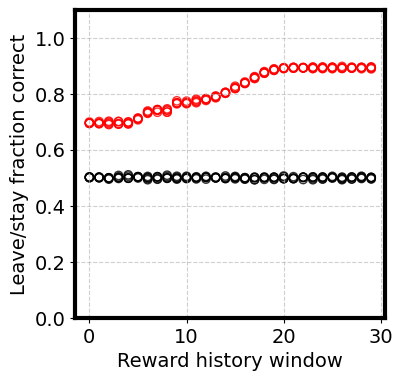

In [41]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
all_pred_accuracies = []

for k in range(targets.shape[1]):
    y = targets[:, k]

    for reward_hist_size in range(0, 30):
        kf = KFold(n_splits=5, shuffle=True)
        pred_accuracies = []
        shuffled_pred_accuracies = []
        for train_i, test_i in kf.split(covariates, y):
            classifier = LogisticRegression(max_iter=int(1e6))
            reg = classifier.fit(covariates[train_i, :reward_hist_size + 1], y[train_i])
            pred_accuracies.append(reg.score(covariates[test_i, :reward_hist_size + 1], y[test_i]))
            # do regression with shuffled labels
            y_test = y[test_i]
            np.random.shuffle(y_test)
            shuffled_pred_accuracies.append(reg.score(covariates[test_i, :reward_hist_size + 1], y_test))

    
        axs.scatter(np.ones(5) * reward_hist_size, pred_accuracies, alpha=0.8, facecolor='none', edgecolor='red')
        axs.scatter(np.ones(5) * reward_hist_size, shuffled_pred_accuracies, alpha=0.8, facecolor='none', edgecolor='black')


axs.set_ylabel('Leave/stay fraction correct')
axs.set_xlabel('Reward history window')

axs.grid(True, linestyle='--', alpha=0.6)
axs.set_ylim(0, 1.1)

In [42]:
covariates = []
targets = []

for env_idx in range(0, 210):
    session_data = all_session_data[env_idx]
    trajs_by_patch_type = find_odor_site_trajectories_by_patch_type(session_data)
    for k in reversed(range(3)):
        trajs_for_patch_type = trajs_by_patch_type[k]

        reward_history = []
        for i in range(len(trajs_for_patch_type)):
            curr_traj = trajs_for_patch_type[i]

            attempted = session_data['current_reward_site_attempted'][curr_traj].sum() > 0
            covariates.append(data[curr_traj, env_idx, :][0, :])
            targets.append(attempted)

covariates = np.stack(covariates)
targets = np.array(targets).reshape((len(targets), 1)).astype(int)

sampler = RandomUnderSampler()
covariates, targets = sampler.fit_resample(covariates, targets)
targets = targets.reshape(targets.shape[0], 1)

print(covariates.shape)
print(targets.shape)

(101142, 160)
(101142, 1)


(0.0, 1.1)

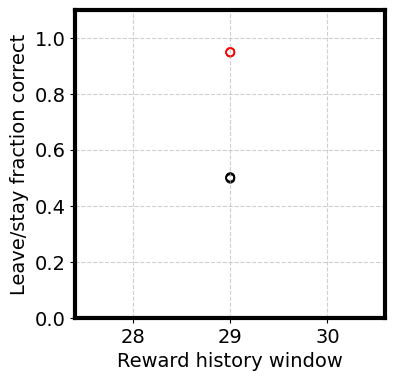

In [43]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
all_pred_accuracies = []

for k in range(targets.shape[1]):
    y = targets[:, k]

    kf = KFold(n_splits=5, shuffle=True)
    pred_accuracies = []
    shuffled_pred_accuracies = []
    for train_i, test_i in kf.split(covariates, y):
        classifier = LogisticRegression(max_iter=int(1e6))
        reg = classifier.fit(covariates[train_i, :], y[train_i])
        pred_accuracies.append(reg.score(covariates[test_i, :], y[test_i]))
        # do regression with shuffled labels
        y_test = y[test_i]
        np.random.shuffle(y_test)
        shuffled_pred_accuracies.append(reg.score(covariates[test_i, :], y_test))


    axs.scatter(np.ones(5) * reward_hist_size, pred_accuracies, alpha=0.8, facecolor='none', edgecolor='red')
    axs.scatter(np.ones(5) * reward_hist_size, shuffled_pred_accuracies, alpha=0.8, facecolor='none', edgecolor='black')


axs.set_ylabel('Leave/stay fraction correct')
axs.set_xlabel('Reward history window')

axs.grid(True, linestyle='--', alpha=0.6)
axs.set_ylim(0, 1.1)

0
30
60
90
120
150
180


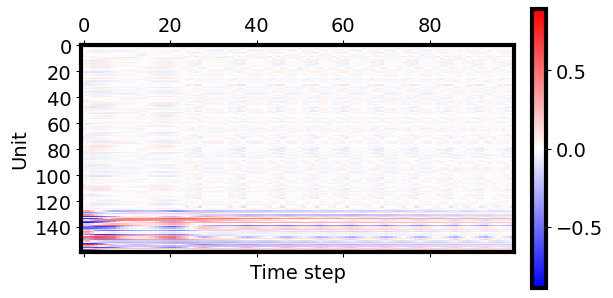

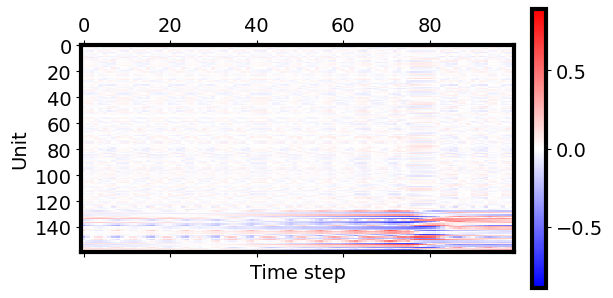

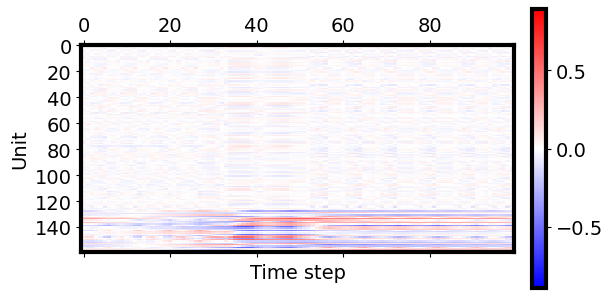

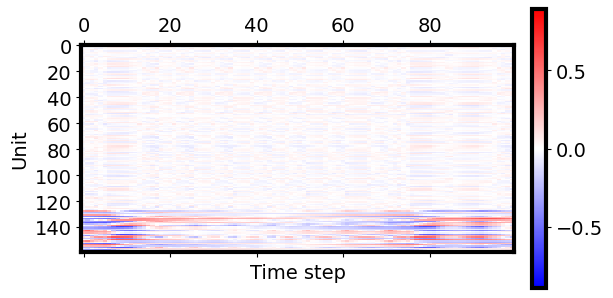

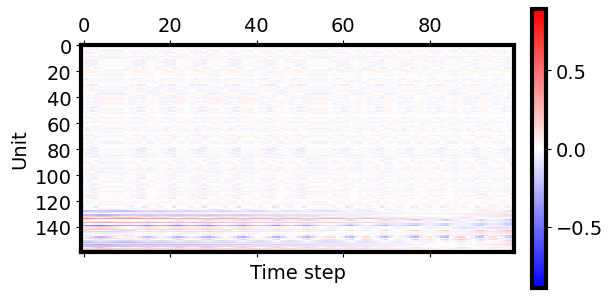

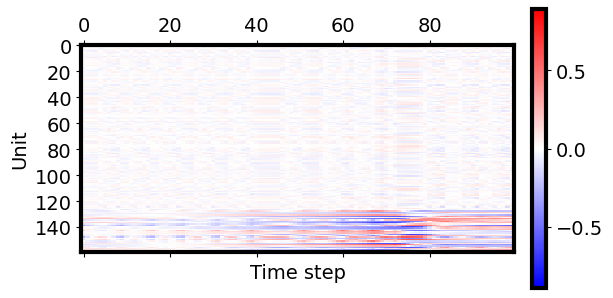

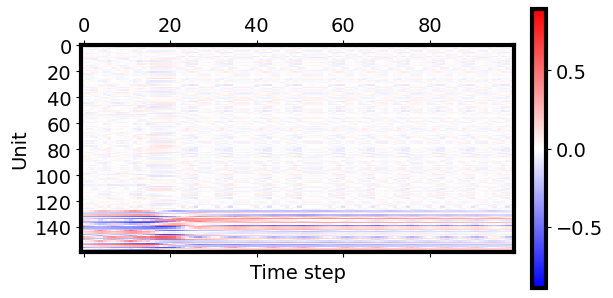

In [47]:
m = np.abs(data).max()


for k in range(0, 210, 30):
    print(k)
    hidden_activity = data[300:400, k, :].T
    
    scale = 1.5
    fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
    axs.set_ylabel('Unit')
    axs.set_xlabel('Time step')

    cbar = axs.matshow(hidden_activity, vmin=-m, vmax=m, cmap='bwr', aspect=0.3)
    plt.colorbar(cbar, fraction=0.03, pad=0.04)

In [44]:
hidden_states = []
targets = []

for env_idx in range(0, 210):
    session_data = all_session_data[env_idx]
    trajs_by_patch_type = find_odor_site_trajectories_by_patch_type(session_data)
    for k in range(3):
        trajs_for_patch_type = trajs_by_patch_type[k]
        for i in range(len(trajs_for_patch_type)):
            if i < 100:
                curr_traj = trajs_for_patch_type[i]
                hidden_states.append(data[curr_traj, env_idx, :])
                targets.append(np.array([
                    session_data['reward_site_idx'][curr_traj],
                    session_data['rewards_seen_in_patch'][curr_traj],
                    session_data['patch_reward_param'][curr_traj],
                ]))

hidden_states = np.concatenate(hidden_states, axis=0)
targets = np.concatenate(targets, axis=1).T

first_site_hidden_states = []
first_site_targets = []

for env_idx in range(0, 210):
    session_data = all_session_data[env_idx]
    trajs_by_patch_type = find_odor_site_trajectories_by_patch_type(session_data, first_site_only=True)
    for k in range(3):
        trajs_for_patch_type = trajs_by_patch_type[k]
        for i in range(len(trajs_for_patch_type)):
            if i < 100:
                curr_traj = trajs_for_patch_type[i]
                first_site_hidden_states.append(data[curr_traj, env_idx, :])
                first_site_targets.append(np.array([
                    session_data['patch_reward_param'][curr_traj],
                ]))

first_site_hidden_states = np.concatenate(first_site_hidden_states, axis=0)
first_site_targets = np.concatenate(first_site_targets, axis=1).T

(272984, 160)
[-0.9290437443869834, -0.9199853268105382, -0.88949448586504, -0.8450707167155913, -0.9152537006512111]
(272984, 160)
[-0.861861522331482, -0.8705630545513727, -0.860017079937383, -0.841364918973651, -0.8533752475496827]
(272984, 160)
[0.39535139293367766, 0.39091891495869735, 0.3958092935509277, 0.3915599758228474, 0.3927027621071141]
[0.38048512276101254, 0.38549707107661724, 0.38298052318819126, 0.38377109503870066, 0.38425749693355327]


(0.0, 1.1)

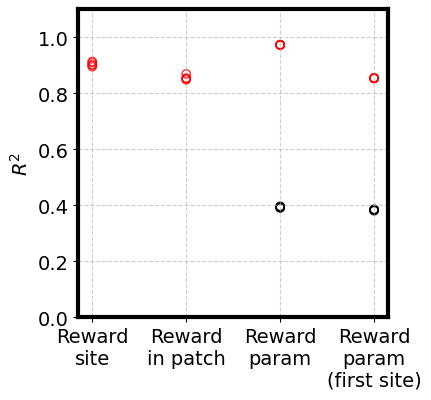

In [45]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
all_pred_accuracies = []

reg_types = [
    LinearRegression,
    LinearRegression,
    LogisticRegression,
]

hidden_states_pool = hidden_states[:, -32:]
first_site_hidden_states_pool = first_site_hidden_states[:, -32:]

for k in range(targets.shape[1]):
    pred_accuracies = []
    shuffled_pred_accuracies = []
    y = targets[:, k]

    print(hidden_states.shape)
    
    kf = KFold(n_splits=5)
    for train_i, test_i in kf.split(hidden_states_pool, y):
        # do normal regression
        if k == 2:
            classifier = reg_types[k](max_iter=int(1e6))
        else:
            classifier = reg_types[k]()
        reg = classifier.fit(hidden_states_pool[train_i, :], y[train_i])
        pred_accuracies.append(reg.score(hidden_states_pool[test_i, :], y[test_i]))
        # do regression with shuffled labels
        y_test = y[test_i]
        np.random.shuffle(y_test)
        shuffled_pred_accuracies.append(reg.score(hidden_states_pool[test_i, :], y_test))

    
    all_pred_accuracies.append(pred_accuracies)
    axs.scatter(np.ones(5) * k, pred_accuracies, alpha=0.8, facecolor='none', edgecolor='red')
    print(shuffled_pred_accuracies)
    axs.scatter(np.ones(5) * k, shuffled_pred_accuracies, alpha=0.8, facecolor='none', edgecolor='black')

for k in range(first_site_targets.shape[1]):
    pred_accuracies = []
    shuffled_pred_accuracies = []
    y = first_site_targets[:, k]
    
    kf = KFold(n_splits=5)
    for train_i, test_i in kf.split(first_site_hidden_states_pool, y):
        classifier = LogisticRegression(max_iter=int(1e6))
        reg = classifier.fit(first_site_hidden_states_pool[train_i, :], y[train_i])
        pred_accuracies.append(reg.score(first_site_hidden_states_pool[test_i, :], y[test_i]))
        # do regression with shuffled labels
        y_test = y[test_i]
        np.random.shuffle(y_test)
        shuffled_pred_accuracies.append(reg.score(first_site_hidden_states_pool[test_i, :], y_test))

    all_pred_accuracies.append(pred_accuracies)
    x = np.ones(5) * k + targets.shape[1]
    axs.scatter(x, pred_accuracies, alpha=0.8, facecolor='none', edgecolor='red')
    print(shuffled_pred_accuracies)
    axs.scatter(x, shuffled_pred_accuracies, alpha=0.8, facecolor='none', edgecolor='black')


axs.set_ylabel(r'$R^2$')
axs.set_xticks(np.arange(targets.shape[1] + first_site_targets.shape[1]))
axs.set_xticklabels([
    'Reward\nsite',
    'Reward\nin patch',
    'Reward\nparam',
    'Reward\nparam\n(first site)',
])
axs.grid(True, linestyle='--', alpha=0.6)
axs.set_ylim(0, 1.1)

(272984, 160)
[-0.9207420802979038, -0.940631224948763, -0.9004228552991729, -0.8609552563771341, -0.8960586268244299]
(272984, 160)
[-0.8747654058715648, -0.8723294390059146, -0.8608713077742707, -0.8652321267073741, -0.8717571171289544]
(272984, 160)
[0.3991244940198179, 0.4015605253035881, 0.4015605253035881, 0.39535139293367766, 0.4016228295113195]
[0.3872946052826358, 0.3865967390614757, 0.38365724194810413, 0.3846804551029903, 0.3873239436619718]


(0.0, 1.1)

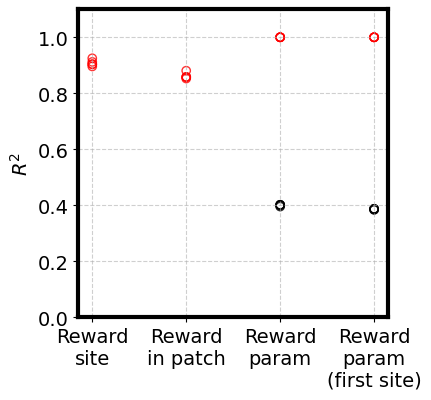

In [46]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
all_pred_accuracies = []

reg_types = [
    LinearRegression,
    LinearRegression,
    LogisticRegression,
]

hidden_states_pool = hidden_states[:, :-32]
first_site_hidden_states_pool = first_site_hidden_states[:, :-32]

for k in range(targets.shape[1]):
    pred_accuracies = []
    shuffled_pred_accuracies = []
    y = targets[:, k]

    print(hidden_states.shape)
    
    kf = KFold(n_splits=5)
    for train_i, test_i in kf.split(hidden_states_pool, y):
        # do normal regression
        if k == 2:
            classifier = reg_types[k](max_iter=int(1e6))
        else:
            classifier = reg_types[k]()
        reg = classifier.fit(hidden_states_pool[train_i, :], y[train_i])
        pred_accuracies.append(reg.score(hidden_states_pool[test_i, :], y[test_i]))
        # do regression with shuffled labels
        y_test = y[test_i]
        np.random.shuffle(y_test)
        shuffled_pred_accuracies.append(reg.score(hidden_states_pool[test_i, :], y_test))

    
    all_pred_accuracies.append(pred_accuracies)
    axs.scatter(np.ones(5) * k, pred_accuracies, alpha=0.8, facecolor='none', edgecolor='red')
    print(shuffled_pred_accuracies)
    axs.scatter(np.ones(5) * k, shuffled_pred_accuracies, alpha=0.8, facecolor='none', edgecolor='black')

for k in range(first_site_targets.shape[1]):
    pred_accuracies = []
    shuffled_pred_accuracies = []
    y = first_site_targets[:, k]
    
    kf = KFold(n_splits=5)
    for train_i, test_i in kf.split(first_site_hidden_states_pool, y):
        classifier = LogisticRegression(max_iter=int(1e6))
        reg = classifier.fit(first_site_hidden_states_pool[train_i, :], y[train_i])
        pred_accuracies.append(reg.score(first_site_hidden_states_pool[test_i, :], y[test_i]))
        # do regression with shuffled labels
        y_test = y[test_i]
        np.random.shuffle(y_test)
        shuffled_pred_accuracies.append(reg.score(first_site_hidden_states_pool[test_i, :], y_test))

    all_pred_accuracies.append(pred_accuracies)
    x = np.ones(5) * k + targets.shape[1]
    axs.scatter(x, pred_accuracies, alpha=0.8, facecolor='none', edgecolor='red')
    print(shuffled_pred_accuracies)
    axs.scatter(x, shuffled_pred_accuracies, alpha=0.8, facecolor='none', edgecolor='black')


axs.set_ylabel(r'$R^2$')
axs.set_xticks(np.arange(targets.shape[1] + first_site_targets.shape[1]))
axs.set_xticklabels([
    'Reward\nsite',
    'Reward\nin patch',
    'Reward\nparam',
    'Reward\nparam\n(first site)',
])
axs.grid(True, linestyle='--', alpha=0.6)
axs.set_ylim(0, 1.1)